In [ ]:
from random import choices
from sage.all import *
from sage.rings.integer_ring import ZZ
import numpy as np
import time
import matplotlib.pyplot as plt

In [37]:
### Define helper functions

def recover_sparse_cyclotomic(p: int, t: int, Mscale=10 ** 10, Nscale=20, noise=0.0) -> tuple[list[int], Matrix]:
    """For a randomly generated cyclotomic integer `z` summed from `l` `p`th roots of unity,
    generates LLL (short, nearly orthogonal) basis vectors to approximate `z` with integer relations. \n

    Each basis vector `vec` consists of:
    - `vec[0:2]` corresponding to the Re and Im parts of the objective value.
    - `vec[2:p+2]` corresponding to the coefficients for each root of unity.
    - `vec[p+2]` corresponding to the target value.

    ### Parameters:
    - `p`: order of root of unity.
    - `t`: number of nonzero integer terms in cyclotomic integer decomposition.
    - `Mscale`: lattice scaling factor for objective complex values.
    - `Nscale`: lattice scaling factor for number of vectors summed.
    - `noise`: standard deviation of Gaussian noise to include in input cyclotomic integer.

    ### Returns:
    - `exps`: list of exponents of roots of unity used to generate z.
    - `lll_mat`: list of candidate basis vectors as output of LLL algorithm.
    """

    # TODO: can LLL be implemented in complex domain? is it better?
    # TODO: find whether there is a better initial ordering of basis vectors
    # TODO: merge with Dylan's code

    # Initialize roots of unity
    roots_re = [math.cos(2 * pi * i / p) for i in range(p)]
    roots_im = [math.sin(2 * pi * i / p) for i in range(p)]

    # Generate random cyclotomic integer
    X = [0]*p
    exps = choices(range(p), k=t)
    for i in exps:
        X[i] += 1
    z_re = np.dot(X, roots_re)
    z_im = np.dot(X, roots_im)

    # Add complex random Gaussian noise with stdev noise
    if noise:
        z_re += np.random.normal(scale=noise/math.sqrt(2))
        z_im += np.random.normal(scale=noise/math.sqrt(2))

    # Construct the lattice basis matrix
    B = Matrix(ZZ, p + 1, p + 3)

    for i in range(p):
        B[i, 0] = int(round(Mscale * roots_re[i])) # roots of unity real parts
        B[i, 1] = int(round(Mscale * roots_im[i])) # roots of unity imaginary parts
        B[i, 2 + i] = Nscale # identity matrix
        B[i, -1] = 1 # L_1 norm enforcement row
    
    # Set target row to real + imaginary parts and target superposition value
    B[-1, 0] = -1 * int(round(Mscale * z_re))
    B[-1, 1] = -1 * int(round(Mscale * z_im))
    B[-1, -1] = -t

    B_lll = B.LLL()
    return exps, B_lll


def filter_candidate(vec: list[int], p: int, t: int, Nscale: int) -> bool:
    """Check whether candidate vector satisfies constraints of 
    the cyclotomic integer decomposition integer relation problem.

    ### Parameters:
    - `vec`: row vector to evaluate of `lll_mat` from `recover_sparse_cyclotomic`.
    - `p`: order of root of unity.
    - `t`: number of expected nonzero integer terms.
    - `Nscale`: lattice scaling factor for integer mapping.

    ### Returns:
    - boolean indicating whether `vec` satisfies the following:
    \t - `abs(vec)[:-1]` has sum equivalent to `t`.
    \t - `abs(vec)[-1]` indicates one multiple of the target value is included in basis vector.
    """
    
    # Check that p and vec are compatible
    if not (len(vec) == p or len(vec) == p + 1):
        raise ValueError("vec is not compatible with the given p")

    # Check for equivalence
    return (np.abs(vec[-1]) % p == 0) and (np.sum(vec[:-1]) % (p * Nscale) == (t * Nscale) % (p * Nscale) or -np.sum(vec[:-1]) % (p * Nscale) == (t * Nscale) % (p * Nscale))

    # return False


def run_trials(orders: list[int], t: int, Mscale: int, Nscale: int, num_trials: int, noise: float) -> list[int]:
    """Tests success rate of using LLL algorithm to solve
    the cyclotomic integer decomposition integer relation problem.

    ### Parameters:
    - `orders`: list of orders of root of unity to test.
    - `t`: number of nonzero integer terms in cyclotomic integer decomposition.
    - `Mscale`: lattice scaling factor for objective complex values.
    - `Nscale`: lattice scaling factor for integer mapping. If set to 0:
    \t - in the noiseless case (`noise == 0.0`), `Nscale` defaults to `1`.
    \t - in the noisy case, computes optimal `Nscale` for each prime in `primes` for best success rate.
    - `noise`: standard deviation of Gaussian noise to include in input cyclotomic integer.

    ### Returns:
    - `results`: list of number of successes corresponding to `orders`.
    """

    # Generate placeholder to record correct trials and time taken for each prime
    results = np.zeros(len(orders))
    
    for i in range(len(orders)):
        # autocomputes Nscale if given noise
        if Nscale == 0 and noise != 0:
            Nval = (2 * Mscale * orders[i] * noise) // (4.5 * (t ** (2/3)))
        else:
            Nval = max(Nscale, 1)

        for j in range(num_trials):
            exps, lll_mat = recover_sparse_cyclotomic(orders[i], t, Mscale=Mscale, Nscale=Nval, noise=noise)
            bool_arr = np.array([filter_candidate(row[2:], orders[i], t, Nscale=Nval) for row in np.array(lll_mat)])
            candidates = np.array(lll_mat)[bool_arr]

            # Match successful candidate vectors
            if candidates.any():
                # Construct desired histogram of roots of unity
                expected_arr = np.zeros(orders[i])
                for exp in exps:
                    expected_arr[exp] += Nval

                # Check if candidate vector and desired histogram differ by all 1's vector
                candidate = candidates[0]
                diff_vec_pos = candidate[2:-1] - expected_arr
                diff_vec_neg = candidate[2:-1] + expected_arr
                if (diff_vec_pos == diff_vec_pos[0]).all() or (diff_vec_neg == diff_vec_neg[0]).all():
                    results[i] += 1
    return results


def run_trials_timed(orders: list[int], t: int, Mscale: int, Nscale: int, num_trials: int, noise: float) -> tuple[list[int], list[float]]:
    """Tests success rate and times of using LLL algorithm to solve
    the cyclotomic integer decomposition integer relation problem.
    See `run_trials` for input details.

    ### Returns:
    - `results`: list of number of successes corresponding to `orders`.
    - `times`: list of times (in seconds) needed to run all trials for each prime in `orders`.
    """

    # Generate placeholder to record correct trials and time taken for each prime
    results = np.zeros(len(orders))
    times = np.zeros(len(orders))
    # init_time = time.time()
    
    for i in range(len(orders)):
        start_time = time.time()
        
        # autocomputes Nscale if given noise
        if Nscale == 0 and noise != 0:
            Nval = (2 * Mscale * orders[i] * noise) // (4.5 * (t ** (2/3)))
        else:
            Nval = max(Nscale, 1)

        for j in range(num_trials):
            exps, lll_mat = recover_sparse_cyclotomic(orders[i], t, Mscale=Mscale, Nscale=Nval, noise=noise)
            bool_arr = np.array([filter_candidate(row[2:], orders[i], t, Nscale=Nval) for row in np.array(lll_mat)])
            candidates = np.array(lll_mat)[bool_arr]

            # Match successful candidate vectors
            if candidates.any():
                # Construct desired histogram of roots of unity
                expected_arr = np.zeros(orders[i])
                for exp in exps:
                    expected_arr[exp] += Nval

                # Check if candidate vector and desired histogram differ by all 1's vector
                candidate = candidates[0]
                diff_vec_pos = candidate[2:-1] - expected_arr
                diff_vec_neg = candidate[2:-1] + expected_arr
                if (diff_vec_pos == diff_vec_pos[0]).all() or (diff_vec_neg == diff_vec_neg[0]).all():
                    results[i] += 1
        
        # End and record times for prime
        times[i] = time.time() - start_time
    return results, times


In [ ]:
### Check LLL matrix output and selected candidates for a single trial
exps, lll_mat = recover_sparse_cyclotomic(11, 3, Mscale=10**3, Nscale=2, noise=(10 ** -3))
bool_arr = np.array([filter_candidate(row[2:], 11, 3, Nscale=2) for row in np.array(lll_mat)])
candidates = np.array(lll_mat)[bool_arr]

print(exps)
print(lll_mat)
print(candidates)

[0, 3, 7]
[ 1  0  2  0  0  2  0  0  0  2  0  0  0  1]
[-1  0  0  2  2  0  2  2  2  0  2  2  2 -1]
[ 2 -1  0  2  2  0  0  0  2 -2  2  0  0  4]
[ 1  1  0 -4  2 -2  0 -2 -2  0  2 -2 -2 -3]
[ 0 -3  0 -2  4 -2  2  2 -2 -2  2  2  0  2]
[ 1 -4  2  2 -2 -2  0 -2  2  2 -2 -2 -2 -1]
[-1  0  2  0  0 -4  2 -2  0  0  2 -6  0  1]
[ 5 -1  2  2 -2 -2  2  2  2 -2 -2  2  0  1]
[-2 -1  4  2  2 -2 -2  2  0  2  2 -2 -4  1]
[ 3 -1 -2  4  2 -2  0  0 -2  2  4 -2 -2  0]
[-1  0 -2  2 -2  4  0  0  0 -2  6 -2  2 -1]
[-1  1  2  2 -2  0  2 -4  2  0 -2  2 -4  3]
[]


In [42]:
### Run trials

# As of last commit: this space iterates through potential error and superposition values. 
# A prime stops being tested when its accuracy values fall too low.

# primes = [11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
# primes = [7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47]
# primes = [37, 41, 43, 47]

trials = 1000
# orders = [11, 13, 17, 19, 23]
Mlogs = np.arange(3, 16)
Nlogs = np.arange(0.5, 13, 0.5)
t = 3

for Mlog in Mlogs:
    for Nlog in Nlogs:
        results = run_trials(orders=[11], t=t, Mscale=10 ** Mlog, Nscale=int(10 ** Nlog), num_trials=trials, noise=0.01)
        print(f"log M = {Mlog}, log N = {Nlog}: {results}")

print(f"Results: {results}")
# print(f"Times: {times}")

Results: [1000.  102. 1000.  370.  665.  478. 1000.  325. 1000.  594.  788.  651.
 1000.  428. 1000.  717.  859.  729. 1000.  468.  998.  789.  891.  773.
 1000.  448. 1000.  827.  900.  857.  999.  563. 1000.  839.  922.  855.
 1000.  578. 1000.  891.  943.  878. 1000.  569. 1000.  898.  925.  890.
 1000.  584. 1000.  910.  941.  906.  980.  524.  917.  911.  948.  918.
  999.  602.  739.  913.  951.  914.  660.  636.  656.  919.  965.  921.
  572.  674.  507.  922.  954.  924.  402.  647.  373.  929.  663.  934.
  398.  580.  285.  927.  297.  940.  269.  693.  249.  939.  293.]


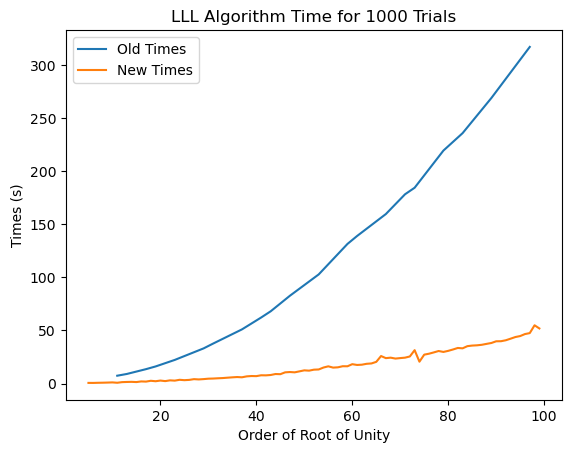

In [40]:
### Plot algorithm times for old code and new code

primes = [11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
y_old = [7.39, 9.03, 13.57, 16.12, 22.28, 33.12, 37.69, 51.03, 62.22, 68.12, 82.75, 102.83, 131.57, 139.03, 159.72, 178.36, 184.52, 219.53, 235.96, 269.08, 317.2]
orders = np.arange(5, 100)
y_new = [
    0.618, 0.592, 0.723, 0.804, 0.926, 1.082,
    0.743, 1.326, 1.495, 1.605, 1.397, 1.997,
    1.836, 2.602, 2.190, 2.808, 2.301, 3.006,
    2.751, 3.533, 3.182, 3.444, 4.147, 3.884,
    4.187, 4.590, 4.722, 4.969, 5.174, 5.530,
    5.858, 6.137, 5.899, 6.770, 7.089, 6.985,
    7.793, 7.721, 8.064, 8.984, 8.825, 10.560,
    10.855, 10.569, 11.496, 12.439, 12.154, 13.076,
    13.272, 15.096, 16.231, 15.027, 15.292, 16.318,
    16.279, 18.254, 17.521, 17.766, 18.615, 18.937,
    20.446, 25.922, 23.943, 24.390, 23.534, 23.990,
    24.396, 25.519, 31.465, 20.600, 27.235, 28.129,
    29.351, 30.667, 29.793, 30.806, 32.101, 33.531,
    33.187, 35.240, 35.786, 36.028, 36.525, 37.391,
    38.218, 39.824, 39.887, 40.784, 42.277, 43.828,
    44.749, 46.626, 47.544, 54.902, 51.937
]
plt.plot(primes, y_old, label="Old Times")
plt.plot(orders, y_new, label="New Times")
plt.title("LLL Algorithm Time for 1000 Trials")
plt.xlabel("Order of Root of Unity")
plt.ylabel("Times (s)")
plt.legend()
plt.show()

/tmp/ipykernel_1617/2174724989.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


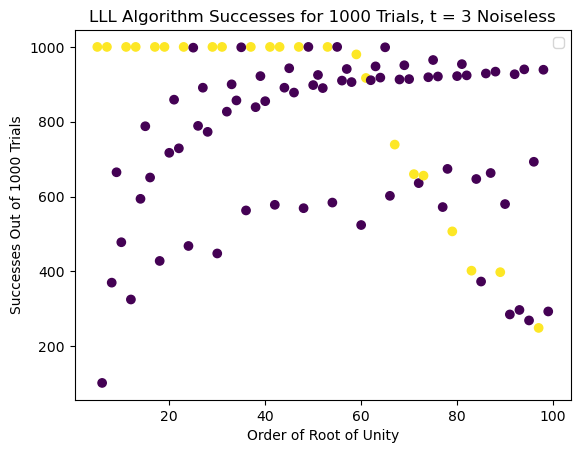

In [46]:
### Plot successes over p for t = 3

orders = np.arange(5, 100)
results = [
    1000.0, 102.0, 1000.0, 370.0, 665.0, 478.0, 1000.0, 325.0, 1000.0, 594.0, 788.0, 651.0,
    1000.0, 428.0, 1000.0, 717.0, 859.0, 729.0, 1000.0, 468.0, 998.0, 789.0, 891.0, 773.0,
    1000.0, 448.0, 1000.0, 827.0, 900.0, 857.0, 999.0, 563.0, 1000.0, 839.0, 922.0, 855.0,
    1000.0, 578.0, 1000.0, 891.0, 943.0, 878.0, 1000.0, 569.0, 1000.0, 898.0, 925.0, 890.0,
    1000.0, 584.0, 1000.0, 910.0, 941.0, 906.0, 980.0, 524.0, 917.0, 911.0, 948.0, 918.0,
    999.0, 602.0, 739.0, 913.0, 951.0, 914.0, 660.0, 636.0, 656.0, 919.0, 965.0, 921.0,
    572.0, 674.0, 507.0, 922.0, 954.0, 924.0, 402.0, 647.0, 373.0, 929.0, 663.0, 934.0,
    398.0, 580.0, 285.0, 927.0, 297.0, 940.0, 269.0, 693.0, 249.0, 939.0, 293.0
]
plt.scatter(orders, results, c=[is_prime(p) for p in orders])
plt.title("LLL Algorithm Successes for 1000 Trials, t = 3 Noiseless")
plt.xlabel("Order of Root of Unity")
plt.ylabel("Successes Out of 1000 Trials")
plt.legend()
plt.show()

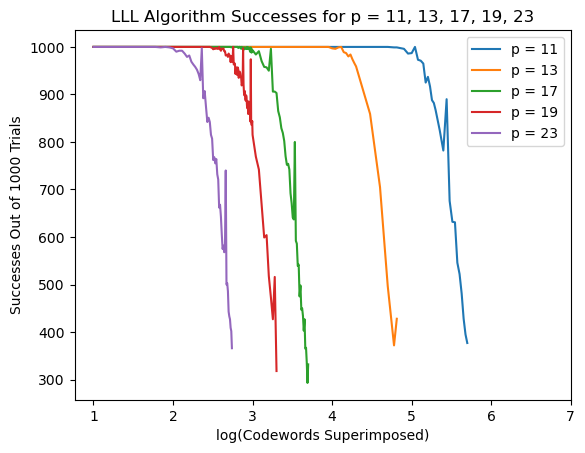

In [ ]:
### Plot algorithm successes for p = 11, 13, 17, 19, 23 (outdated)

codewords11 = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 30000, 40000, 50000, 60000, 65000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000, 225000, 250000, 275000, 300000, 325000, 350000, 375000, 400000, 425000, 450000, 475000, 500000]
codewords13 = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 30000, 40000, 50000, 60000, 65000]
codewords17 = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000]
codewords19 = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
codewords23 = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550]
log_cwords11 = np.log10(codewords11)
log_cwords13 = np.log10(codewords13)
log_cwords17 = np.log10(codewords17)
log_cwords19 = np.log10(codewords19)
log_cwords23 = np.log10(codewords23)
successes11 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 999, 998, 996, 986, 987, 1000, 973, 971, 965, 925, 937, 917, 888, 882, 867, 825, 782, 890, 676, 632, 631, 546, 522, 481, 428, 395, 377]
successes13 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 997, 996, 999, 1000, 989, 987, 980, 984, 974, 966, 959, 859, 705, 497, 372, 428]
successes17 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 998, 998, 1000, 1000, 999, 999, 996, 1000, 999, 999, 999, 999, 997, 995, 999, 999, 998, 996, 997, 1000, 996, 999, 998, 996, 999, 997, 993, 990, 997, 999, 996, 988, 995, 990, 993, 984, 991, 970, 958, 957, 950, 996, 906, 906, 903, 865, 852, 829, 819, 802, 770, 752, 754, 742, 692, 671, 641, 637, 800, 592, 586, 539, 542, 475, 498, 447, 450, 434, 403, 427, 365, 367, 336, 293, 332]
successes19 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 998, 995, 997, 996, 998, 996, 996, 1000, 995, 992, 996, 996, 997, 991, 991, 982, 983, 983, 979, 986, 981, 982, 968, 981, 972, 968, 1000, 963, 963, 965, 943, 957, 951, 941, 957, 953, 935, 945, 948, 945, 937, 934, 919, 923, 925, 997, 921, 904, 898, 907, 891, 887, 898, 894, 877, 871, 885, 859, 885, 880, 864, 861, 856, 843, 974, 842, 836, 837, 844, 815, 769, 742, 668, 599, 604, 518, 473, 427, 516, 318]
successes23 = [1000, 1000, 1000, 1000, 1000, 1000, 999, 1000, 999, 997, 990, 992, 992, 986, 979, 982, 969, 963, 958, 952, 943, 930, 997, 892, 907, 873, 842, 851, 842, 815, 807, 762, 768, 755, 764, 732, 721, 662, 668, 643, 606, 575, 582, 568, 578, 740, 500, 503, 486, 443, 433, 427, 409, 402, 366]
plt.plot(log_cwords11, successes11, label='p = 11')
plt.plot(log_cwords13, successes13, label='p = 13')
plt.plot(log_cwords17, successes17, label='p = 17')
plt.plot(log_cwords19, successes19, label='p = 19')
plt.plot(log_cwords23, successes23, label='p = 23')
plt.title("LLL Algorithm Successes for p = 11, 13, 17, 19, 23")
plt.xlabel("log(Codewords Superimposed)")
plt.xticks([1, 2, 3, 4, 5, 6, 7])
plt.ylabel("Successes Out of 1000 Trials")
plt.legend()
plt.show()

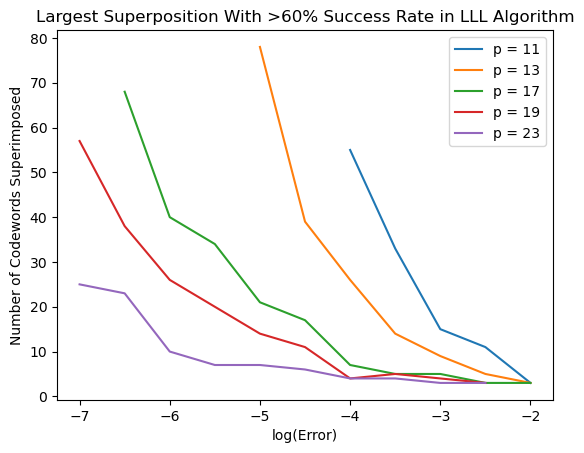

In [ ]:
### Plot max superposition for p = 11, 13, 17, 19, 23 vs error (outdated)

log_error11 = np.arange(-4.0, -1.5, 0.5)
log_error13 = np.arange(-5.0, -1.5, 0.5)
log_error17 = np.arange(-6.5, -1.5, 0.5)
log_error19 = np.arange(-7.0, -2.0, 0.5)
successes11e = [55, 33, 15, 11, 3]
successes13e = [78, 39, 26, 14, 9, 5, 3]
successes17e = [68, 40, 34, 21, 17, 7, 5, 5, 3, 3]
successes19e = [57, 38, 26, 20, 14, 11, 4, 5, 4, 3]
successes23e = [25, 23, 10, 7, 7, 6, 4, 4, 3, 3]
plt.plot(log_error11, successes11e, label='p = 11')
plt.plot(log_error13, successes13e, label='p = 13')
plt.plot(log_error17, successes17e, label='p = 17')
plt.plot(log_error19, successes19e, label='p = 19')
plt.plot(log_error19, successes23e, label='p = 23')
plt.title("Largest Superposition With >60% Success Rate in LLL Algorithm")
plt.xlabel("log(Error)")
plt.xticks([-7, -6, -5, -4, -3, -2])
plt.ylabel("Number of Codewords Superimposed")
plt.legend()
plt.show()


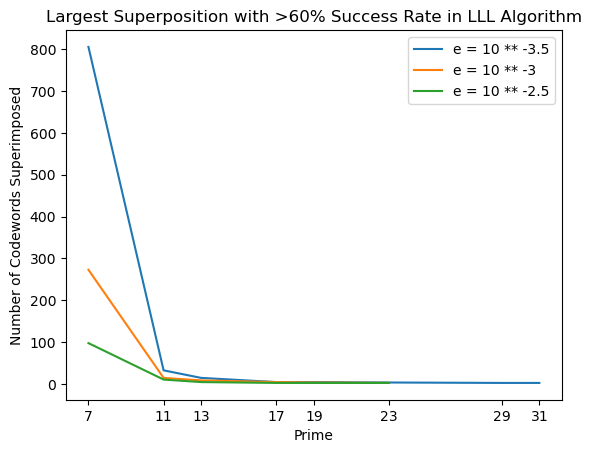

In [ ]:
### Plot max superposition for e = 10 ** -3.5 (outdated)
primes_25 = [7, 11, 13, 17, 19, 23]
primes_35 = [7, 11, 13, 17, 19, 23, 29, 31]
superpositions25 = [98, 11, 5, 3, 3, 3]
superpositions30 = [273, 15, 9, 5, 4, 3]
superpositions35 = [805, 33, 15, 5, 5, 4, 3, 3]
plt.plot(primes_35, superpositions35, label="e = 10 ** -3.5")
plt.plot(primes_25, superpositions30, label="e = 10 ** -3")
plt.plot(primes_25, superpositions25, label="e = 10 ** -2.5")
plt.title("Largest Superposition with >60% Success Rate in LLL Algorithm")
plt.xlabel("Prime")
plt.xticks(primes_35)
plt.ylabel("Number of Codewords Superimposed")
plt.legend()
plt.show()